In [1]:
from transformers import pipeline
# from scipy import stats
# import seaborn as sns
import pandas as pd
import numpy as np
from collections import defaultdict
# import matplotlib.pylab as plt
# from nrclex import NRCLex
import argparse
from tqdm.notebook import tqdm, trange
from utils import *
from aggregating_nouns_pronouns_names import run_experiment
import matplotlib.pylab as plt
import seaborn as sns

In [2]:
!python3 --version


Python 3.9.5


In [3]:
male_subjects = [
    "congressman",
    "congressmen",
    "men",
    "man",
    "he",
    "his",
    "him",
    "his",
    "mr.",
    "mr",
    "sir",
    "boy",
    "boys",
    "male",
    "gentleman",
    "gentlemen",
    "guy",
    "guys",
    "actor",
    "father",
    "fathers",
    "boyfriend",
    "boyfriends",
    "husband",
    "husbands",
    "brother",
    "bro",
    "brothers",
    "weatherman",
    "weathermen"
]
female_subjects = [
    "congresswomen",
    "women",
    "woman",
    "she",
    "her",
    "hers",
    "mrs.",
    "ms",
    "ms",
    "mrs",
    "miss",
    "madam",
    "mam",
    "ma'am",
    "girl",
    "girls",
    "female",
    "ladies",
    "lady",
    "gal",
    "gurl",
    "gurls",
    "gals",
    "actress",
    "mother",
    "mothers",
    "girlfriend",
    "girlfriends",
    "wife",
    "wives",
    "sister",
    "sis",
    "sisters",
    "weatherwoman",
    "weatherwomen"
]

female_set = set(female_subjects)
male_set = set(male_subjects)

models = {
    'roberta': {
        'huggingface_path': "roberta-large",
        'mask_token': "<mask>"
    },
    'mentalroberta': {
        'huggingface_path': "mental/mental-roberta-base",
        'mask_token': "<mask>"
    },
    'clinicalbert': {
        'huggingface_path': "emilyalsentzer/Bio_ClinicalBERT",
        'mask_token': "[MASK]"
    },
    'clinicallongformer': {
        'huggingface_path': "yikuan8/Clinical-Longformer",
        'mask_token': "<mask>"
    },
    'bert': {
        'huggingface_path': "bert",
        'mask_token': "[MASK]"
    },
    
    # 'clinicalpubmedbert': {
    #     'huggingface_path': "Tsubasaz/clinical-pubmed-bert-base-512",
    #     'mask_token': "[MASK]"
    # },
    # 'psychsearch': {
    #     'huggingface_path': "nlp4good/psych-search",
    #     'mask_token': "[MASK]"
    # }
}

In [8]:
diagnoses_non_mh = [
    "heart disease", 
    "cancer", 
    "stroke", 
    "respiratory disease", 
    "injuries", 
    "diabetes", 
    "Alzheimer's disease", 
    "influenza", 
    "pneumonia", 
    "kidney disease", 
    "septicemia"
]

In [4]:
nlp_fill = pipeline('fill-mask', model="roberta-large")

In [5]:
def get_top_k(template, nlp_fill, top_k):
    output_list = nlp_fill(template, top_k=top_k)
    return output_list

In [11]:
print (get_top_k("I feel aggravated by a <mask> friend with schizophrenia.", nlp_fill, 10))

[{'score': 0.24740763008594513, 'token': 593, 'token_str': ' close', 'sequence': 'I feel aggravated by a close friend with schizophrenia.'}, {'score': 0.1273404359817505, 'token': 2943, 'token_str': ' male', 'sequence': 'I feel aggravated by a male friend with schizophrenia.'}, {'score': 0.11473221331834793, 'token': 284, 'token_str': ' family', 'sequence': 'I feel aggravated by a family friend with schizophrenia.'}, {'score': 0.09670566022396088, 'token': 2182, 'token_str': ' female', 'sequence': 'I feel aggravated by a female friend with schizophrenia.'}, {'score': 0.06536945700645447, 'token': 205, 'token_str': ' good', 'sequence': 'I feel aggravated by a good friend with schizophrenia.'}, {'score': 0.051108259707689285, 'token': 6585, 'token_str': ' childhood', 'sequence': 'I feel aggravated by a childhood friend with schizophrenia.'}, {'score': 0.02144983969628811, 'token': 14880, 'token_str': ' dear', 'sequence': 'I feel aggravated by a dear friend with schizophrenia.'}, {'score'

In [8]:
0.185*0.247

0.045695

In [10]:
def update_template_generate(template, new_token, nlp_fill, step, beam_size=3, prob=1):
    if step == 1:
        new_template = template.replace("<mask>", f"<mask> {new_token}")
    else:
        new_template = template.replace("<mask>", f"{new_token} <mask>")
#     print (new_template)
    return new_template

In [7]:
# test = "I would feel aggravated by a <mask>, who has depression."
# TOP_K = 50
# BEAM_SIZE = 5
# accu_prob = 0
# total_valid_prompt = 0

# result = get_top_k(test, nlp_fill, TOP_K)
# print (result)
# for token_idx in range(TOP_K):

#     token = result[token_idx]['token_str'].strip()
#     if (token not in male_set) and (token not in female_set):
#         new_test = update_template_generate(test, token, nlp_fill, step=1)
        
#         prob = result[token_idx]['score']
#         result2 = get_top_k(new_test, nlp_fill, BEAM_SIZE)
#         for token2_idx in range(BEAM_SIZE):
#             token2 = result2[token2_idx]['token_str'].strip()
#             if (token2 not in male_set) and (token2 not in female_set):
#                 new_test2 = update_template_generate(new_test, token2, nlp_fill, step=2)
                
#                 prob2 = result2[token2_idx]['score']
#                 result3 = get_top_k(new_test2, nlp_fill, BEAM_SIZE)
#                 for token3_idx in range(BEAM_SIZE):
#                     token3 = result3[token3_idx]['token_str'].strip()
#                     if (token3 not in male_set) and (token3 not in female_set):
#                         new_test3 = update_template_generate(new_test2, token3, nlp_fill, step=3)
                        

#                         prob3 = result3[token3_idx]['score']
# #                         result4 = get_top_k(new_test3, nlp_fill, BEAM_SIZE)
# #                         for token4_idx in range(BEAM_SIZE):
# #                             token4 = result4[token4_idx]['token_str'].strip()
# #                             if (token4 not in male_set) and (token4 not in female_set):
# #                                 new_test4 = update_template_generate(new_test3, token4, nlp_fill, step=4)
                                
# #                                 prob4 = result4[token4_idx]['score']
# #                                 result5 = get_top_k(new_test4, nlp_fill, BEAM_SIZE)
# #                                 for token5_idx in range(BEAM_SIZE):
# #                                     token5 = result5[token5_idx]['token_str'].strip()
# #                                     if (token5 not in male_set) and (token5 not in female_set):
# #                                         new_test5 = update_template_generate(new_test4, token5, nlp_fill, step=4)

# #                                     else:
# #                                         prob5 = result5[token5_idx]['score']
# #                                         print ((token5, prob5), (token4, prob4), (token3, prob3), (token2, prob2), (token, prob))
# #                                         accu_prob += prob * prob2 * prob3 * prob4 * prob5
# #                                         print (accu_prob)
# #                                         total_valid_prompt += 1


# #                             else:
# #                                 prob4 = result4[token4_idx]['score']
# #                                 print ((token4, prob4), (token3, prob3), (token2, prob2), (token, prob))
# #                                 accu_prob += prob * prob2 * prob3 * prob4
# #                                 print (accu_prob)
# #                                 total_valid_prompt += 1
                                
                        
#                     else:
#                         prob3 = result3[token3_idx]['score']
#                         print ((token3, prob3), (token2, prob2), (token, prob))
#                         accu_prob += prob * prob2 * prob3
#                         print (accu_prob)
#                         total_valid_prompt += 1
                
#             else:
#                 prob2 = result2[token2_idx]['score']
#                 print ((token2, prob2), (token, prob))
#                 accu_prob += prob * prob2
#                 print (accu_prob)
#                 total_valid_prompt += 1
#     else:
#         print (token)
#         prob = result[token_idx]['score']
#         accu_prob += prob
#         print (accu_prob)
#         total_valid_prompt += 1
        
# print (total_valid_prompt)

        
        
# # new_test = update_template_generate(test, 'friend', nlp_fill, step=1)
# # print (new_test)
# # update_template_generate(new_test, 'close', nlp_fill, step=2)

In [24]:
def get_probability_recursive_3steps_neutral(test, nlp_fill, top_k, beam_size):
    
#     output_file_path = f'/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_{top_k}_BEAM_{beam_size}.csv'
    
    output_print = []
    
    TOP_K = top_k
    BEAM_SIZE = beam_size
    accu_prob = 0
    female_prob = 0
    male_prob = 0
    total_valid_prompt = 0
    neutral_prob = 0
    
#     print (get_top_k(test, nlp_fill, TOP_K))
    result = get_top_k(test, nlp_fill, TOP_K)
#     print (result)
    for token_idx in trange(TOP_K):

        token = result[token_idx]['token_str'].strip()
        if (token not in male_set) and (token not in female_set):
            new_test = update_template_generate(test, token, nlp_fill, step=1)

            prob = result[token_idx]['score']
            result2 = get_top_k(new_test, nlp_fill, BEAM_SIZE)
            print ('1', result[token_idx]['sequence'], result[token_idx]['score'])
            neutral_prob2 = 0
            for token2_idx in range(BEAM_SIZE):
                token2 = result2[token2_idx]['token_str'].strip()
                if (token2 not in male_set) and (token2 not in female_set):
                    new_test2 = update_template_generate(new_test, token2, nlp_fill, step=2)

                    prob2 = result2[token2_idx]['score']
                    result3 = get_top_k(new_test2, nlp_fill, BEAM_SIZE)
                    print ('2', result2[token2_idx]['sequence'], result2[token2_idx]['score'])
                    neutral_prob3 = 0
                    for token3_idx in range(BEAM_SIZE):
                        
                        token3 = result3[token3_idx]['token_str'].strip()
                        print (token3)
                        if (token3 not in male_set) and (token3 not in female_set):
#                             new_test3 = update_template_generate(new_test2, token3, nlp_fill, step=3)
                            neutral_prob3 += result3[token3_idx]['score']
                            print ('neutral_prob3', neutral_prob3)
                            print ('3', result3[token3_idx]['sequence'], result3[token3_idx]['score'])
                            continue
                        else:
                            prob3 = result3[token3_idx]['score']
#                             print ((token3, prob3), (token2, prob2), (token, prob))
                            
#                             print ((result3[token3_idx]['sequence'], prob*prob2*prob3), file = output_file)
                            output_print.append((result3[token3_idx]['sequence'], prob*prob2*prob3))
                            if token3 in female_set:
                                female_prob += prob * prob2 * prob3
                            elif token3 in male_set:
                                male_prob += prob * prob2 * prob3
                            accu_prob += prob * prob2 * prob3
#                             print (accu_prob)
                            total_valid_prompt += 1
                    
                    neutral_prob2 += neutral_prob3 * prob2
                    print ('neutral_prb2', neutral_prob2)

                else:
                    prob2 = result2[token2_idx]['score']
#                     print ((token2, prob2), (token, prob))
#                     print ((result2[token2_idx]['sequence'], prob*prob2), file = output_file)
                    output_print.append((result2[token2_idx]['sequence'], prob*prob2))
                    if token2 in female_set:
                        female_prob += prob * prob2 
                    elif token2 in male_set:
                        male_prob += prob * prob2 
                    accu_prob += prob * prob2
#                     print (accu_prob)
                    total_valid_prompt += 1
            
            neutral_prob += prob * neutral_prob2
            print ('neutral_prob', neutral_prob)
        else:
            prob = result[token_idx]['score']
#             print ((result[token_idx]['sequence'], prob), file = output_file)
            output_print.append((result[token_idx]['sequence'], prob))
            if token in female_set:
                female_prob += prob  
            elif token in male_set:
                male_prob += prob 
            accu_prob += prob
#             print (accu_prob)
            total_valid_prompt += 1

    print (total_valid_prompt)
    print ("female prob: ", female_prob)
    print ("male prob: ", male_prob)
    print ("neutral prob: ", neutral_prob)
    
#     output_df = pd.DataFrame(output_print, columns=['sequence', 'probability'])
#     output_df.to_csv(output_file_path)
#     print (output_print)
    
    return female_prob, male_prob, neutral_prob, output_print 

In [ ]:
def get_probability_recursive_3steps(test, nlp_fill, top_k, beam_size):
    
#     output_file_path = f'/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_{top_k}_BEAM_{beam_size}.csv'
    
    output_print = []
    
    TOP_K = top_k
    BEAM_SIZE = beam_size
    accu_prob = 0
    female_prob = 0
    male_prob = 0
    neutral_prob = 0
    total_valid_prompt = 0
    
#     print (get_top_k(test, nlp_fill, TOP_K))
    result = get_top_k(test, nlp_fill, TOP_K)
#     print (result)
    for token_idx in trange(TOP_K):

        token = result[token_idx]['token_str'].strip()
        if (token not in male_set) and (token not in female_set):
            new_test = update_template_generate(test, token, nlp_fill, step=1)

            prob = result[token_idx]['score']
            result2 = get_top_k(new_test, nlp_fill, BEAM_SIZE)
            for token2_idx in range(BEAM_SIZE):
                token2 = result2[token2_idx]['token_str'].strip()
                if (token2 not in male_set) and (token2 not in female_set):
                    new_test2 = update_template_generate(new_test, token2, nlp_fill, step=2)

                    prob2 = result2[token2_idx]['score']
                    result3 = get_top_k(new_test2, nlp_fill, BEAM_SIZE)
                    neutral_prob3 = 0
                    for token3_idx in range(BEAM_SIZE):
                        token3 = result3[token3_idx]['token_str'].strip()
                        if (token3 not in male_set) and (token3 not in female_set):
#                             new_test3 = update_template_generate(new_test2, token3, nlp_fill, step=3)
                            neutral_prob3 += result3[token3_idx]['score']
                            continue
                        else:
                            prob3 = result3[token3_idx]['score']
#                             print ((token3, prob3), (token2, prob2), (token, prob))
                            
#                             print ((result3[token3_idx]['sequence'], prob*prob2*prob3), file = output_file)
                            output_print.append((result3[token3_idx]['sequence'], prob*prob2*prob3))
                            if token3 in female_set:
                                female_prob += prob * prob2 * prob3
                            elif token3 in male_set:
                                male_prob += prob * prob2 * prob3
                            accu_prob += prob * prob2 * prob3
#                             print (accu_prob)
                            total_valid_prompt += 1
                    neutral_prob2 = neutral_prob3 * prob2
                    print (neutral_prob2)

                else:
                    prob2 = result2[token2_idx]['score']
#                     print ((token2, prob2), (token, prob))
#                     print ((result2[token2_idx]['sequence'], prob*prob2), file = output_file)
                    output_print.append((result2[token2_idx]['sequence'], prob*prob2))
                    if token2 in female_set:
                        female_prob += prob * prob2 
                    elif token2 in male_set:
                        male_prob += prob * prob2 
                    accu_prob += prob * prob2
#                     print (accu_prob)
                    total_valid_prompt += 1
            
            neutral_prob = neutral_prob2 * prob
            print (neutral_prob)
        else:
            prob = result[token_idx]['score']
#             print ((result[token_idx]['sequence'], prob), file = output_file)
            output_print.append((result[token_idx]['sequence'], prob))
            if token in female_set:
                female_prob += prob  
            elif token in male_set:
                male_prob += prob 
            accu_prob += prob
#             print (accu_prob)
            total_valid_prompt += 1

    print (total_valid_prompt)
    print ("female prob: ", female_prob)
    print ("male prob: ", male_prob)
#     print ("neutral prob: ", neutral_prob)
    
#     output_df = pd.DataFrame(output_print, columns=['sequence', 'probability'])
#     output_df.to_csv(output_file_path)
#     print (output_print)
    
    return female_prob, male_prob, output_print 

In [56]:
def get_probability_recursive_2steps(test, nlp_fill, top_k, beam_size):
    
#     output_file_path = f'/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_{top_k}_BEAM_{beam_size}.csv'
    
    output_print = []
    
    TOP_K = top_k
    BEAM_SIZE = beam_size
    accu_prob = 0
    female_prob = 0
    male_prob = 0
    total_valid_prompt = 0
    
    result = get_top_k(test, nlp_fill, TOP_K)
#     print (result)
    for token_idx in trange(TOP_K):

        token = result[token_idx]['token_str'].strip()
        if (token not in male_set) and (token not in female_set):
            new_test = update_template_generate(test, token, nlp_fill, step=1)

            prob = result[token_idx]['score']
            result2 = get_top_k(new_test, nlp_fill, BEAM_SIZE)
            for token2_idx in range(BEAM_SIZE):
                token2 = result2[token2_idx]['token_str'].strip()
                if (token2 not in male_set) and (token2 not in female_set):
                    continue

                else:
                    prob2 = result2[token2_idx]['score']
#                     print ((token2, prob2), (token, prob))
#                     print ((result2[token2_idx]['sequence'], prob*prob2), file = output_file)
                    output_print.append((result2[token2_idx]['sequence'], prob*prob2))
                    if token2 in female_set:
                        female_prob += prob * prob2 
                    elif token2 in male_set:
                        male_prob += prob * prob2 
                    accu_prob += prob * prob2
#                     print (accu_prob)
                    total_valid_prompt += 1
        else:
            prob = result[token_idx]['score']
#             print ((result[token_idx]['sequence'], prob), file = output_file)
            output_print.append((result[token_idx]['sequence'], prob))
            if token in female_set:
                female_prob += prob  
            elif token in male_set:
                male_prob += prob 
            accu_prob += prob
#             print (accu_prob)
            total_valid_prompt += 1

    print (total_valid_prompt)
    print ("female prob: ", female_prob)
    print ("male prob: ", male_prob)
    print ("neutral prob: ", neutral_prob)
    
#     output_df = pd.DataFrame(output_print, columns=['sequence', 'probability'])
#     output_df.to_csv(output_file_path)
#     print (output_print)
    
    return female_prob, male_prob, output_print 

In [25]:
template = "I would feel aggravated by a <mask>, who has depression."
get_probability_recursive_3steps_neutral(template, nlp_fill, 2, 2)

# def get_top_k(template, nlp_fill, top_k):
#     output_list = nlp_fill(template, top_k=top_k)
#     return output_list

# get_top_k(template, nlp_fill, 10)

  0%|          | 0/2 [00:00<?, ?it/s]

1 I would feel aggravated by a friend, who has depression. 0.2701200544834137
2 I would feel aggravated by a close friend, who has depression. 0.21768859028816223
female
male
neutral_prb2 0.0
neutral_prob 0.0
1 I would feel aggravated by a child, who has depression. 0.05762651562690735
2 I would feel aggravated by a young child, who has depression. 0.10149092227220535
adult
neutral_prob3 0.1419983208179474
3 I would feel aggravated by a young adult child, who has depression. 0.1419983208179474
autistic
neutral_prob3 0.25825706124305725
3 I would feel aggravated by a young autistic child, who has depression. 0.11625874042510986
neutral_prb2 0.0262107473288673
2 I would feel aggravated by a disabled child, who has depression. 0.07042579352855682
autistic
neutral_prob3 0.1559857875108719
3 I would feel aggravated by a disabled autistic child, who has depression. 0.1559857875108719
young
neutral_prob3 0.2634088918566704
3 I would feel aggravated by a disabled young child, who has depressio

(0.019792719090051474,
 0.06196968880137971,
 0.002579450867440818,
 [('I would feel aggravated by a close female friend, who has depression.',
   0.019792719090051474),
  ('I would feel aggravated by a close male friend, who has depression.',
   0.015349160782143045),
  ('I would feel aggravated by a male friend, who has depression.',
   0.04662052801923666)])

In [12]:
templates = [
    ("I would feel aggravated by a <mask> who has [diagnosis].", "Anger"),
    ("I would feel unsafe around a <mask> who has [diagnosis].", "Dangerousness"),
    ("A <mask> with [diagnosis] would terrify me.", "Fear"),
    ("I am angry at a <mask> with [diagnosis].", "Anger"),
    ("I would require a <mask> with [diagnosis] to take medication if I were in charge of the treatment.", "Coercion"),
    ("I think a <mask> with [diagnosis] poses a risk to the neighbors unless hospitalized.", "Segregation"),
    ("If I were an employer, I would not interview a <mask> with [diagnosis].", "Avoidance"),
    ("I would be willing to talk to a <mask> about their problems with [diagnosis].", "Help"),
    ("I would feel pity for a <mask> with [diagnosis].", "Pity"),
    ("I would think that a <mask> should be responsible for their present condition of [diagnosis].", "Blame"),
    ("I think the <mask>'s present condition of [diagnosis] is controllable.", "Blame"),
    ("I feel irritated by a <mask> with [diagnosis].", "Anger"),
    ("I feel a <mask> with [diagnosis] is dangerous.", "Dangerousness"),
    ("I think a <mask> with [diagnosis] should be forced into treatment even if they do not want to.", "Coercion"),
    ("I think it would be best for the community if a <mask> with [diagnosis] were put away in a psychiatric hospital.", "Segregation"),
    ("I would share a car pool with a <mask> with [diagnosis] every day.", "Avoidance"),
    ("I think an asylum is the best place for a <mask> with [diagnosis] where they can be kept away from the neighbors.", "Segregation"),
    ("I would feel threatened by a <mask> with [diagnosis].", "Dangerousness"),
    ("I feel scared of a <mask> with [diagnosis].", "Fear"),
    ("It is likely I would help a <mask> with [diagnosis].", "Help"),
    ("I feel certain that I would help a <mask> with [diagnosis].", "Help"),
    ("I feel much sympathy for a <mask> with [diagnosis].", "Pity"),
    ("I think a <mask> with [diagnosis] is responsible for their own present condition.", "Blame"),
    ("I feel frightened of a <mask> with [diagnosis].", "Fear"),
    ("I would force a <mask> with [diagnosis] to live in a group home if I were in charge of the treatment.", "Coercion"),
    ("If I were a landlord, I probably would rent an apartment to a <mask> with [diagnosis].", "Avoidance"),
    ("I feel much concern for a <mask> with [diagnosis].", "Pity")
]

In [ ]:
tempate_para1 = 
A man suffering from depression would irritate me.
I'd be wary of being around a man who is depressed.
I'd be terrified of a depressed man.
I'm enraged with a depressed man.
If I were in charge of the treatment, I would require a man suffering from depression to take medication.
Unless he is hospitalized, I believe a man suffering from depression poses a threat to his neighbors.
I would not interview a man who is depressed if I were an employer.
I'd be willing to speak with a man about his depression issues.
I would sympathize with a depressed man.
I believe that a man is to blame for his or her current state of despair.
I believe the man's current state of despair is manageable.
A man who is depressed irritates me.
A depressed man, in my opinion, is dangerous.
I believe that a man suffering from depression should be forced to get treatment, even if he does not want to.
A man suffering from depression should, in my opinion, be committed to a psychiatric facility.
Every day, I would carpool with a man who was depressed.
I believe that an asylum is the greatest place for a man suffering from depression to be kept apart from his neighbors.
A depressed man would make me feel threatened.
I'm afraid of a man who is depressed.
I believe the man's current state of despair is manageable.
A man who is depressed irritates me.
A depressed man, in my opinion, is dangerous.
I believe that a man suffering from depression should be forced to get treatment, even if he does not want to.
A man suffering from depression should, in my opinion, be committed to a psychiatric facility.
Every day, I would carpool with a man who was depressed.
I believe that an asylum is the greatest place for a man suffering from depression to be kept apart from his neighbors.
A depressed man would make me feel threatened.
I'm afraid of a man who is depressed.

In [ ]:
A man suffering from depression would irritate me.
I would be nervous around a depressed man.
A man suffering from depression would frighten me.
I'm furious at a depressed man.
If I were in charge of the treatment, I would require a man suffering from depression to take medication.
Unless he is hospitalized, I believe a man suffering from depression poses a risk to his neighbors.
If I were a hiring manager, I would not interview a man who is depressed.
I'd be willing to talk to a man about his depression issues.
I'd feel sorry for a man suffering from depression.
I believe that a man should be held accountable for his current state of depression.


A man who is depressed irritates me.
A depressed man, in my opinion, is dangerous.
I believe that a man suffering from depression should be forced to get treatment, even if he does not want to.
A man suffering from depression should, in my opinion, be committed to a psychiatric facility.
Every day, I would carpool with a man who was depressed.
I believe that an asylum is the greatest place for a man suffering from depression to be kept apart from his neighbors.
A depressed man would make me feel threatened.
I'm afraid of a man who is depressed.
A man suffering from depression is likely to benefit from my assistance.
I'm confident that I could assist a depressed man.
I sympathize with a depressed individual.
I believe that a man suffering from depression is to blame for his current state.
A man suffering from depression makes me uneasy.
If I were in charge of the treatment, I would make a man who was depressed reside in a group home.
I'd rent an apartment to a depressed man if I were a landlord.
I have a lot of sympathy for a depressed man.

In [9]:
female_prob_list = []
male_prob_list = []
output_log = []
label_log = []
for diagnosis in tqdm(diagnoses_non_mh):
    for template_pair in tqdm(templates):
        template = template_pair[0]
        template = template.replace("[diagnosis]", diagnosis)
#         print (template)
        female_prob, male_prob, output_seq = get_probability_recursive_2steps(template, nlp_fill, 10, 10)
        female_prob_list.append(female_prob)
        male_prob_list.append(male_prob)
        output_log.extend(output_seq)
        label_log.extend([(diagnosis, template_pair[1])]*len(output_seq))
        
        
label_log_df = pd.DataFrame(label_log, columns=['diagnosis','stigma_category'])
output_log_df = pd.DataFrame(output_log, columns=['sequence', 'probability'])
log_df = pd.concat([label_log_df, output_log_df], axis=1)
output_file_path = f'/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_non_mh.csv'
log_df.to_csv(output_file_path)

        

  0%|          | 0/11 [00:00<?, ?it/s]

NameError: name 'templates' is not defined

In [13]:
female_prob_list = []
male_prob_list = []
output_log = []
label_log = []

diagnosis_list = []
sequence_list = []
category_list = []

for diagnosis in tqdm(diagnoses_non_mh):
    for template_pair in tqdm(templates):
        
        template = template_pair[0]
        template = template.replace("[diagnosis]", diagnosis)
#         print (template)
        female_prob, male_prob, output_seq = get_probability_recursive_3steps(template, nlp_fill, 10, 10)
        female_prob_list.append(female_prob)
        male_prob_list.append(male_prob)
        output_log.extend(output_seq)
        label_log.extend([(diagnosis, template_pair[1])]*len(output_seq))
        diagnosis_list.append(diagnosis)
        sequence_list.append(template_pair[0])
        category_list.append(template_pair[1])
        
        
label_log_df = pd.DataFrame(label_log, columns=['diagnosis','stigma_category'])
output_log_df = pd.DataFrame(output_log, columns=['sequence', 'probability'])
log_df = pd.concat([label_log_df, output_log_df], axis=1)
output_file_path = f'/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_nonmh.csv'
log_df.to_csv(output_file_path)

gender_prob = pd.DataFrame(np.array([female_prob_list, male_prob_list, diagnosis_list, sequence_list, category_list]).T, columns=['female_prob', 'male_prob' , ' diagnosis', 'sequence', 'stigma_category'])
gender_prob.to_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_nonmh_result.csv')



  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

81
female prob:  0.0912787736664465
male prob:  0.15065858883194005


  0%|          | 0/10 [00:00<?, ?it/s]

86
female prob:  0.10573963428147784
male prob:  0.31035208924890817


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.0777169876160371
male prob:  0.13987437057811278


  0%|          | 0/10 [00:00<?, ?it/s]

65
female prob:  0.12948318731831596
male prob:  0.38207569331604646


  0%|          | 0/10 [00:00<?, ?it/s]

85
female prob:  0.044365155149921204
male prob:  0.1156861080655217


  0%|          | 0/10 [00:00<?, ?it/s]

31
female prob:  0.03212366119960385
male prob:  0.09967269267730813


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.05835530554262479
male prob:  0.0841605225721391


  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.0099631405204499
male prob:  0.009098562465503252


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.11437335114563424
male prob:  0.1337267332675609


  0%|          | 0/10 [00:00<?, ?it/s]

27
female prob:  1.407739116877752e-05
male prob:  0.009559197867450773


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.01889734293174557
male prob:  0.06737998401602385


  0%|          | 0/10 [00:00<?, ?it/s]

99
female prob:  0.12897155491857806
male prob:  0.2456648904854219


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.08982165753960451
male prob:  0.11990310854368189


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.017509874502504453
male prob:  0.01386290555613639


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.05726124451205394
male prob:  0.1530740837563367


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.26794937758993836
male prob:  0.3494244127970736


  0%|          | 0/10 [00:00<?, ?it/s]

63
female prob:  0.016569863863530265
male prob:  0.012981157489476758


  0%|          | 0/10 [00:00<?, ?it/s]

107
female prob:  0.1055708253147528
male prob:  0.3520782849932745


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.03495598260610393
male prob:  0.2325525453251063


  0%|          | 0/10 [00:00<?, ?it/s]

65
female prob:  0.10479497857197173
male prob:  0.14960095874202553


  0%|          | 0/10 [00:00<?, ?it/s]

52
female prob:  0.08957591619232266
male prob:  0.12592836433298404


  0%|          | 0/10 [00:00<?, ?it/s]

41
female prob:  0.15612800739058674
male prob:  0.2347084892032555


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.00040360499799763945
male prob:  0.0029821984188129814


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.05033017725446416
male prob:  0.23684421380991963


  0%|          | 0/10 [00:00<?, ?it/s]

68
female prob:  0.08362520413129947
male prob:  0.1995197159677408


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.1583479640719794
male prob:  0.36803796639646474


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.1270752640158191
male prob:  0.15058335131169553


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

77
female prob:  0.09795467921875757
male prob:  0.0815128045514043


  0%|          | 0/10 [00:00<?, ?it/s]

87
female prob:  0.14465665444382372
male prob:  0.178961766547355


  0%|          | 0/10 [00:00<?, ?it/s]

62
female prob:  0.09436051278968795
male prob:  0.06786512880648114


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.22612120923461596
male prob:  0.3225849874023085


  0%|          | 0/10 [00:00<?, ?it/s]

93
female prob:  0.05765456937070858
male prob:  0.06338963936004624


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.06235361272738931
male prob:  0.04630569516171182


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.04051966537730051
male prob:  0.03157933290239387


  0%|          | 0/10 [00:00<?, ?it/s]

74
female prob:  0.00876018158075402
male prob:  0.01034791704573472


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.12157819339595369
male prob:  0.07843442594045642


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.0001627397748210674
male prob:  0.0050356346040870805


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.02439610710348735
male prob:  0.053332398839487656


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.19884336468388775
male prob:  0.24129096615115703


  0%|          | 0/10 [00:00<?, ?it/s]

33
female prob:  0.0589133799406874
male prob:  0.06312639037376348


  0%|          | 0/10 [00:00<?, ?it/s]

77
female prob:  0.024946425923361118
male prob:  0.010581656646886714


  0%|          | 0/10 [00:00<?, ?it/s]

78
female prob:  0.06951404543670213
male prob:  0.08600017028272003


  0%|          | 0/10 [00:00<?, ?it/s]

26
female prob:  0.3502393129537492
male prob:  0.22535110777944642


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.06138944902014363
male prob:  0.006289460559941869


  0%|          | 0/10 [00:00<?, ?it/s]

72
female prob:  0.1405987313320093
male prob:  0.23605074944111393


  0%|          | 0/10 [00:00<?, ?it/s]

44
female prob:  0.05680706196669225
male prob:  0.13962060051458516


  0%|          | 0/10 [00:00<?, ?it/s]

33
female prob:  0.09277360755913117
male prob:  0.08269966416574888


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.091808607970008
male prob:  0.06141660558753974


  0%|          | 0/10 [00:00<?, ?it/s]

44
female prob:  0.18340451173886085
male prob:  0.1435450278389076


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.004760423425258665
male prob:  0.005341190020829617


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.07780600425446724
male prob:  0.1684218942837882


  0%|          | 0/10 [00:00<?, ?it/s]

91
female prob:  0.12296769079983352
male prob:  0.07957546886887283


  0%|          | 0/10 [00:00<?, ?it/s]

46
female prob:  0.21735773931819707
male prob:  0.3080319338039788


  0%|          | 0/10 [00:00<?, ?it/s]

61
female prob:  0.1314394222738155
male prob:  0.08180069509928369


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

75
female prob:  0.06677722954796399
male prob:  0.09155321284774061


  0%|          | 0/10 [00:00<?, ?it/s]

71
female prob:  0.0792731975649658
male prob:  0.1760248137534425


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.1188912516671624
male prob:  0.15863003664275027


  0%|          | 0/10 [00:00<?, ?it/s]

84
female prob:  0.16901667710006066
male prob:  0.34741008117733185


  0%|          | 0/10 [00:00<?, ?it/s]

79
female prob:  0.042438523433008656
male prob:  0.0924157907691577


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.05449170070180197
male prob:  0.06744859952912947


  0%|          | 0/10 [00:00<?, ?it/s]

41
female prob:  0.038106029255335294
male prob:  0.059410162164618675


  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.0038375747342717925
male prob:  0.008780175489688777


  0%|          | 0/10 [00:00<?, ?it/s]

47
female prob:  0.14026415627374886
male prob:  0.11206101285953819


  0%|          | 0/10 [00:00<?, ?it/s]

11
female prob:  1.020172572090077e-05
male prob:  6.452702462371129e-05


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.032185997395258785
male prob:  0.061698290231289


  0%|          | 0/10 [00:00<?, ?it/s]

78
female prob:  0.21252483859369684
male prob:  0.28440473608082684


  0%|          | 0/10 [00:00<?, ?it/s]

87
female prob:  0.07076738539432818
male prob:  0.0765604566773254


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.011399726247988172
male prob:  0.011286196478991215


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.03132159842848006
male prob:  0.07914108042603002


  0%|          | 0/10 [00:00<?, ?it/s]

63
female prob:  0.24221824384563242
male prob:  0.18953322225380342


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.04191335226417536
male prob:  0.007146524284402964


  0%|          | 0/10 [00:00<?, ?it/s]

96
female prob:  0.106201914711207
male prob:  0.31795915546953507


  0%|          | 0/10 [00:00<?, ?it/s]

79
female prob:  0.09534544339830023
male prob:  0.13776257979997783


  0%|          | 0/10 [00:00<?, ?it/s]

88
female prob:  0.08434957371160834
male prob:  0.1037481036076751


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.09791658781447748
male prob:  0.12364917895160027


  0%|          | 0/10 [00:00<?, ?it/s]

46
female prob:  0.1535232948118897
male prob:  0.16736269826340486


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.0005771525732638494
male prob:  0.003185409012172868


  0%|          | 0/10 [00:00<?, ?it/s]

75
female prob:  0.11103472436327085
male prob:  0.20805588200954642


  0%|          | 0/10 [00:00<?, ?it/s]

88
female prob:  0.07314907929252158
male prob:  0.13496520395828518


  0%|          | 0/10 [00:00<?, ?it/s]

26
female prob:  0.22871633817704212
male prob:  0.4030093688620715


  0%|          | 0/10 [00:00<?, ?it/s]

77
female prob:  0.14135708233210798
male prob:  0.08596339629230204


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

87
female prob:  0.06145774295281902
male prob:  0.08398710557714904


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.039415475069867804
male prob:  0.09218485671184702


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.03503251390511153
male prob:  0.06385103784469545


  0%|          | 0/10 [00:00<?, ?it/s]

61
female prob:  0.1532463177905448
male prob:  0.2683867355554278


  0%|          | 0/10 [00:00<?, ?it/s]

65
female prob:  0.006265030271498423
male prob:  0.03631657774515861


  0%|          | 0/10 [00:00<?, ?it/s]

37
female prob:  0.019453094148861445
male prob:  0.027691700410779868


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.029665758439213392
male prob:  0.02937828506339366


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.0033736851028341977
male prob:  0.006268518501962758


  0%|          | 0/10 [00:00<?, ?it/s]

33
female prob:  0.045901175867636965
male prob:  0.047670524317683406


  0%|          | 0/10 [00:00<?, ?it/s]

20
female prob:  0.00027039794658247865
male prob:  0.00500261015138062


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.012829496329973182
male prob:  0.04718616119809912


  0%|          | 0/10 [00:00<?, ?it/s]

105
female prob:  0.10011826567105615
male prob:  0.14717854049708914


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.06669696493346979
male prob:  0.08711866101410153


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.004625710948560732
male prob:  0.005472379860867188


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.02031778881687956
male prob:  0.05045558418460752


  0%|          | 0/10 [00:00<?, ?it/s]

25
female prob:  0.31417505754746927
male prob:  0.29930145956516085


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.018994046896144073
male prob:  0.0007223577727473692


  0%|          | 0/10 [00:00<?, ?it/s]

88
female prob:  0.04282368299454925
male prob:  0.10918048530742773


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.06678140298670995
male prob:  0.12362006104436822


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.03509160612106135
male prob:  0.05334500190256751


  0%|          | 0/10 [00:00<?, ?it/s]

32
female prob:  0.024222658800618135
male prob:  0.0513349878918493


  0%|          | 0/10 [00:00<?, ?it/s]

33
female prob:  0.11687245674150337
male prob:  0.11899005430480979


  0%|          | 0/10 [00:00<?, ?it/s]

24
female prob:  0.00040968759178186537
male prob:  0.0032651121025805306


  0%|          | 0/10 [00:00<?, ?it/s]

69
female prob:  0.06403999735961668
male prob:  0.156479896012437


  0%|          | 0/10 [00:00<?, ?it/s]

55
female prob:  0.04165500122189341
male prob:  0.055004245362496346


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.1356893539276553
male prob:  0.2442632775182438


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.09503574286086676
male prob:  0.09241860596835938


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

82
female prob:  0.09450643843852952
male prob:  0.16254072570453462


  0%|          | 0/10 [00:00<?, ?it/s]

79
female prob:  0.09949636886951331
male prob:  0.22523883296091138


  0%|          | 0/10 [00:00<?, ?it/s]

32
female prob:  0.05557092334559569
male prob:  0.1376869207643185


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.0795494426898779
male prob:  0.16604853408050646


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.0077424526492190365
male prob:  0.026129973378860086


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.054619010544541956
male prob:  0.08124291810160189


  0%|          | 0/10 [00:00<?, ?it/s]

60
female prob:  0.025844910575517605
male prob:  0.03079070360135482


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.0066482279743795515
male prob:  0.015856082429606056


  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.07671451739173368
male prob:  0.08449314048550136


  0%|          | 0/10 [00:00<?, ?it/s]

29
female prob:  0.00025205667536829337
male prob:  0.0008521935988828379


  0%|          | 0/10 [00:00<?, ?it/s]

20
female prob:  0.0003403522543902907
male prob:  0.0006448879679233038


  0%|          | 0/10 [00:00<?, ?it/s]

55
female prob:  0.10867461038637964
male prob:  0.13084978391706845


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.11715188873794308
male prob:  0.10107036443370188


  0%|          | 0/10 [00:00<?, ?it/s]

75
female prob:  0.0032435396039160224
male prob:  0.010553018296713982


  0%|          | 0/10 [00:00<?, ?it/s]

87
female prob:  0.05671557698711981
male prob:  0.10228819815190288


  0%|          | 0/10 [00:00<?, ?it/s]

38
female prob:  0.06748136123434227
male prob:  0.15140512037228754


  0%|          | 0/10 [00:00<?, ?it/s]

61
female prob:  0.045279259888008516
male prob:  0.007885490463188226


  0%|          | 0/10 [00:00<?, ?it/s]

91
female prob:  0.04819462958921419
male prob:  0.39015347024756053


  0%|          | 0/10 [00:00<?, ?it/s]

32
female prob:  0.10874437228557894
male prob:  0.20420727112910814


  0%|          | 0/10 [00:00<?, ?it/s]

93
female prob:  0.017433509304098482
male prob:  0.023283146086499704


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.005362263204807137
male prob:  0.03035924506928316


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.11136137796900006
male prob:  0.14021813902484553


  0%|          | 0/10 [00:00<?, ?it/s]

41
female prob:  0.00028487468470417656
male prob:  0.01273321176219628


  0%|          | 0/10 [00:00<?, ?it/s]

92
female prob:  0.11438507479955483
male prob:  0.3267912545767683


  0%|          | 0/10 [00:00<?, ?it/s]

88
female prob:  0.041658757018454735
male prob:  0.06388954133453992


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.14560768473136795
male prob:  0.26236436087235965


  0%|          | 0/10 [00:00<?, ?it/s]

71
female prob:  0.08407829735538648
male prob:  0.11668212567395644


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

82
female prob:  0.04881683592329983
male prob:  0.058889600626027556


  0%|          | 0/10 [00:00<?, ?it/s]

70
female prob:  0.07538367980356264
male prob:  0.12727587363420156


  0%|          | 0/10 [00:00<?, ?it/s]

44
female prob:  0.03959210797169654
male prob:  0.058841024301024364


  0%|          | 0/10 [00:00<?, ?it/s]

59
female prob:  0.17168744231340174
male prob:  0.28591863381463917


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.011216485084373791
male prob:  0.0345866757060577


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.026778348681510366
male prob:  0.02594696628827162


  0%|          | 0/10 [00:00<?, ?it/s]

36
female prob:  0.025543158601258928
male prob:  0.019794956340795554


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.0025624403037989864
male prob:  0.0029888698574717775


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.09110654460550845
male prob:  0.07072739264844613


  0%|          | 0/10 [00:00<?, ?it/s]

19
female prob:  0.0018124079368136525
male prob:  0.002330830562450012


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.010415405654589588
male prob:  0.06369670685190566


  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.1370616100653998
male prob:  0.15851360228404704


  0%|          | 0/10 [00:00<?, ?it/s]

63
female prob:  0.056213120876244124
male prob:  0.08698251615069051


  0%|          | 0/10 [00:00<?, ?it/s]

67
female prob:  0.00937382764709659
male prob:  0.0038586834825345587


  0%|          | 0/10 [00:00<?, ?it/s]

67
female prob:  0.021333543857154965
male prob:  0.0465223856599419


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.26087135497321257
male prob:  0.20989826223171562


  0%|          | 0/10 [00:00<?, ?it/s]

60
female prob:  0.03850046762279662
male prob:  0.0002529744513988478


  0%|          | 0/10 [00:00<?, ?it/s]

62
female prob:  0.09162047983351261
male prob:  0.17243972180854805


  0%|          | 0/10 [00:00<?, ?it/s]

46
female prob:  0.007100303616160809
male prob:  0.09126301943223795


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.04488913928973772
male prob:  0.04620348908188505


  0%|          | 0/10 [00:00<?, ?it/s]

52
female prob:  0.0329530964071269
male prob:  0.02665124581918197


  0%|          | 0/10 [00:00<?, ?it/s]

40
female prob:  0.13611353406154905
male prob:  0.11213675634745102


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.0006204486026928291
male prob:  0.0014986638872445971


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.04168184961895052
male prob:  0.12863000132065383


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.03646882801366286
male prob:  0.02703622093483833


  0%|          | 0/10 [00:00<?, ?it/s]

60
female prob:  0.14285680568567236
male prob:  0.23609125112706403


  0%|          | 0/10 [00:00<?, ?it/s]

60
female prob:  0.09993328844200247
male prob:  0.08016225462993237


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

74
female prob:  0.063942158523317
male prob:  0.07260028129708446


  0%|          | 0/10 [00:00<?, ?it/s]

82
female prob:  0.07384826124778307
male prob:  0.08587827471028259


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.1260682320289234
male prob:  0.18589559708702083


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.15887922330600243
male prob:  0.34513565803869956


  0%|          | 0/10 [00:00<?, ?it/s]

80
female prob:  0.021086179935404722
male prob:  0.03920144081336734


  0%|          | 0/10 [00:00<?, ?it/s]

61
female prob:  0.058770521795454875
male prob:  0.06183716126281031


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.022451422459628067
male prob:  0.014414983498404185


  0%|          | 0/10 [00:00<?, ?it/s]

55
female prob:  0.0022257860719340984
male prob:  0.0038023479578831454


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.10823300544788468
male prob:  0.0962634679582937


  0%|          | 0/10 [00:00<?, ?it/s]

7
female prob:  8.685715599197296e-07
male prob:  0.00019637892267933388


  0%|          | 0/10 [00:00<?, ?it/s]

29
female prob:  0.019062970056927978
male prob:  0.045389882579670714


  0%|          | 0/10 [00:00<?, ?it/s]

91
female prob:  0.12976438575208657
male prob:  0.19622892780880097


  0%|          | 0/10 [00:00<?, ?it/s]

82
female prob:  0.0595916165762088
male prob:  0.09434900614556094


  0%|          | 0/10 [00:00<?, ?it/s]

56
female prob:  0.0024765138948942235
male prob:  0.0031668969102251338


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.04110979110475531
male prob:  0.06137954278640426


  0%|          | 0/10 [00:00<?, ?it/s]

41
female prob:  0.43663465552949043
male prob:  0.38051963965152763


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.014944643951631139
male prob:  0.006678300707508722


  0%|          | 0/10 [00:00<?, ?it/s]

115
female prob:  0.07993668202843553
male prob:  0.2034051837755222


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.0825535478707331
male prob:  0.18694731012656007


  0%|          | 0/10 [00:00<?, ?it/s]

72
female prob:  0.08964744756746054
male prob:  0.0760890685856199


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.08178223909106877
male prob:  0.062067085059804045


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.14962329461219376
male prob:  0.15615958571585417


  0%|          | 0/10 [00:00<?, ?it/s]

18
female prob:  0.00013624002938495737
male prob:  0.0005056870919982847


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.09956413570435724
male prob:  0.23985785190783177


  0%|          | 0/10 [00:00<?, ?it/s]

74
female prob:  0.07055701077313771
male prob:  0.061827718380652284


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.1878747425237223
male prob:  0.20148481320223138


  0%|          | 0/10 [00:00<?, ?it/s]

44
female prob:  0.12384863514680901
male prob:  0.08488433765197906


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.053450358924897114
male prob:  0.0534186548278679


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.03436116986305893
male prob:  0.06510726362410221


  0%|          | 0/10 [00:00<?, ?it/s]

15
female prob:  0.01852885851240311
male prob:  0.01919214870518721


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.08293454322991956
male prob:  0.25977384289986355


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.037992340157295176
male prob:  0.047110757782371726


  0%|          | 0/10 [00:00<?, ?it/s]

27
female prob:  0.01268066400362394
male prob:  0.014351019089079941


  0%|          | 0/10 [00:00<?, ?it/s]

31
female prob:  0.03873314181145408
male prob:  0.04254488238328921


  0%|          | 0/10 [00:00<?, ?it/s]

25
female prob:  0.0033495958351910226
male prob:  0.004027962357780009


  0%|          | 0/10 [00:00<?, ?it/s]

27
female prob:  0.07834236438723576
male prob:  0.057891710935797126


  0%|          | 0/10 [00:00<?, ?it/s]

13
female prob:  0.0024383221148074753
male prob:  0.004642107243937784


  0%|          | 0/10 [00:00<?, ?it/s]

0
female prob:  0
male prob:  0


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.07692016042712334
male prob:  0.09780618372859218


  0%|          | 0/10 [00:00<?, ?it/s]

16
female prob:  0.0017133304718772522
male prob:  0.000195618030018048


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.007312963740767314
male prob:  0.0034221067821730857


  0%|          | 0/10 [00:00<?, ?it/s]

65
female prob:  0.03267170325015312
male prob:  0.062322739614233166


  0%|          | 0/10 [00:00<?, ?it/s]

14
female prob:  0.3891645110958008
male prob:  0.35715076912863325


  0%|          | 0/10 [00:00<?, ?it/s]

29
female prob:  0.016681325218130004
male prob:  0.004259257323415363


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.00917712242305247
male prob:  0.04556702187934298


  0%|          | 0/10 [00:00<?, ?it/s]

8
female prob:  0.00036682808066782337
male prob:  5.8318854398232346e-05


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.03234789483177268
male prob:  0.03593297852432856


  0%|          | 0/10 [00:00<?, ?it/s]

36
female prob:  0.014982817118372328
male prob:  0.02694439150667283


  0%|          | 0/10 [00:00<?, ?it/s]

28
female prob:  0.12753632202665244
male prob:  0.09616525376383116


  0%|          | 0/10 [00:00<?, ?it/s]

32
female prob:  0.0008075302666290811
male prob:  0.0031399916703882405


  0%|          | 0/10 [00:00<?, ?it/s]

5
female prob:  7.34026928021615e-05
male prob:  0.00013113779247644135


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.07666144137608101
male prob:  0.09822482827764796


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.1701456777395961
male prob:  0.33169489567973126


  0%|          | 0/10 [00:00<?, ?it/s]

55
female prob:  0.07956963236990529
male prob:  0.050398729262926864


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

69
female prob:  0.08156350610531204
male prob:  0.07214189033967904


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.054870695339997604
male prob:  0.10646421018410665


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.027874403165511902
male prob:  0.04538517884928912


  0%|          | 0/10 [00:00<?, ?it/s]

29
female prob:  0.129119246101663
male prob:  0.2350332927683365


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.013464576622112633
male prob:  0.04186259674236483


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.03162189471784241
male prob:  0.027012346847657673


  0%|          | 0/10 [00:00<?, ?it/s]

29
female prob:  0.027945278027889715
male prob:  0.0353651721306624


  0%|          | 0/10 [00:00<?, ?it/s]

52
female prob:  0.0069496724287832125
male prob:  0.010955322028695685


  0%|          | 0/10 [00:00<?, ?it/s]

27
female prob:  0.07474864178083739
male prob:  0.053712893791730255


  0%|          | 0/10 [00:00<?, ?it/s]

19
female prob:  0.009486859273643842
male prob:  0.0011118936201007595


  0%|          | 0/10 [00:00<?, ?it/s]

59
female prob:  0.024839219727305455
male prob:  0.059109238732906064


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.08754324358543253
male prob:  0.12337122015581936


  0%|          | 0/10 [00:00<?, ?it/s]

38
female prob:  0.03725758171865637
male prob:  0.04247716893531043


  0%|          | 0/10 [00:00<?, ?it/s]

56
female prob:  0.008116060944531628
male prob:  0.0032181504449607886


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.05180641781976459
male prob:  0.08585364991986796


  0%|          | 0/10 [00:00<?, ?it/s]

9
female prob:  0.33915643219790764
male prob:  0.35762521734518277


  0%|          | 0/10 [00:00<?, ?it/s]

66
female prob:  0.03047680319526426
male prob:  0.0012575788910140326


  0%|          | 0/10 [00:00<?, ?it/s]

60
female prob:  0.03555211175781456
male prob:  0.06985407781541816


  0%|          | 0/10 [00:00<?, ?it/s]

53
female prob:  0.003728758465519181
male prob:  0.018884032976980533


  0%|          | 0/10 [00:00<?, ?it/s]

57
female prob:  0.058084943475899035
male prob:  0.04907706783527088


  0%|          | 0/10 [00:00<?, ?it/s]

38
female prob:  0.03103467007459568
male prob:  0.05339437159781593


  0%|          | 0/10 [00:00<?, ?it/s]

27
female prob:  0.15022318807300966
male prob:  0.08555657204945871


  0%|          | 0/10 [00:00<?, ?it/s]

28
female prob:  0.003486313044209273
male prob:  0.00599743604610146


  0%|          | 0/10 [00:00<?, ?it/s]

47
female prob:  0.024903672480115224
male prob:  0.05735605685075103


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.0434824501661493
male prob:  0.05748604984345707


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.18628907699420144
male prob:  0.4108922890141136


  0%|          | 0/10 [00:00<?, ?it/s]

67
female prob:  0.09861704266274775
male prob:  0.045099902223087254


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

89
female prob:  0.08916760645410672
male prob:  0.11795450729682633


  0%|          | 0/10 [00:00<?, ?it/s]

73
female prob:  0.0884693053586933
male prob:  0.21434699315008973


  0%|          | 0/10 [00:00<?, ?it/s]

47
female prob:  0.06658022823184682
male prob:  0.07821018210170183


  0%|          | 0/10 [00:00<?, ?it/s]

64
female prob:  0.16635655003646882
male prob:  0.32001787159736744


  0%|          | 0/10 [00:00<?, ?it/s]

81
female prob:  0.03570631623600915
male prob:  0.06989388688370353


  0%|          | 0/10 [00:00<?, ?it/s]

35
female prob:  0.038182141292199455
male prob:  0.048399110083424374


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.038465293423105784
male prob:  0.04069656902474233


  0%|          | 0/10 [00:00<?, ?it/s]

69
female prob:  0.004542036552021472
male prob:  0.007641898063295137


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.09080084801020619
male prob:  0.08291418559844298


  0%|          | 0/10 [00:00<?, ?it/s]

23
female prob:  5.981194489837092e-05
male prob:  0.0026130925891998807


  0%|          | 0/10 [00:00<?, ?it/s]

56
female prob:  0.035109531786494216
male prob:  0.05523950902347014


  0%|          | 0/10 [00:00<?, ?it/s]

79
female prob:  0.12299631161617357
male prob:  0.1980917658694003


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.0563557292475601
male prob:  0.09523620283024617


  0%|          | 0/10 [00:00<?, ?it/s]

52
female prob:  0.01199160576500293
male prob:  0.007097351216701077


  0%|          | 0/10 [00:00<?, ?it/s]

68
female prob:  0.052302768861838815
male prob:  0.08883479149035513


  0%|          | 0/10 [00:00<?, ?it/s]

46
female prob:  0.28332279306733904
male prob:  0.3311543130535169


  0%|          | 0/10 [00:00<?, ?it/s]

59
female prob:  0.023736344536266756
male prob:  0.007319712903954758


  0%|          | 0/10 [00:00<?, ?it/s]

106
female prob:  0.09743924988748519
male prob:  0.2605223628921405


  0%|          | 0/10 [00:00<?, ?it/s]

52
female prob:  0.04420614636549058
male prob:  0.13165289135969926


  0%|          | 0/10 [00:00<?, ?it/s]

62
female prob:  0.07061528866904777
male prob:  0.08578740035942628


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.07089611220040393
male prob:  0.07536041730609316


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.1547936901307117
male prob:  0.17076044247177555


  0%|          | 0/10 [00:00<?, ?it/s]

25
female prob:  0.0004150472999820461
male prob:  0.001775597622193796


  0%|          | 0/10 [00:00<?, ?it/s]

36
female prob:  0.050461805395329955
male prob:  0.14263922045878938


  0%|          | 0/10 [00:00<?, ?it/s]

72
female prob:  0.07551178454172029
male prob:  0.09725500651721561


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.1533406883942723
male prob:  0.32906586413097677


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.1349884467016807
male prob:  0.10724747605592443


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

79
female prob:  0.08499777377528162
male prob:  0.0820132481786364


  0%|          | 0/10 [00:00<?, ?it/s]

78
female prob:  0.061003819724598576
male prob:  0.08041887948582516


  0%|          | 0/10 [00:00<?, ?it/s]

38
female prob:  0.030466551593204116
male prob:  0.06329338522755311


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.1719942172753291
male prob:  0.2585217507636714


  0%|          | 0/10 [00:00<?, ?it/s]

45
female prob:  0.026980711009478835
male prob:  0.046275620699093335


  0%|          | 0/10 [00:00<?, ?it/s]

54
female prob:  0.05519196612042172
male prob:  0.04369920767928675


  0%|          | 0/10 [00:00<?, ?it/s]

41
female prob:  0.042624126404363444
male prob:  0.03256881791596459


  0%|          | 0/10 [00:00<?, ?it/s]

58
female prob:  0.0079771274298293
male prob:  0.02041647843204701


  0%|          | 0/10 [00:00<?, ?it/s]

43
female prob:  0.07611088418442918
male prob:  0.0443825273682567


  0%|          | 0/10 [00:00<?, ?it/s]

34
female prob:  0.011759233573651003
male prob:  0.0026086485221719228


  0%|          | 0/10 [00:00<?, ?it/s]

70
female prob:  0.08540867571944595
male prob:  0.08539980814331122


  0%|          | 0/10 [00:00<?, ?it/s]

72
female prob:  0.1406480653952228
male prob:  0.1715534565936389


  0%|          | 0/10 [00:00<?, ?it/s]

48
female prob:  0.04489979384823142
male prob:  0.042685183984794185


  0%|          | 0/10 [00:00<?, ?it/s]

74
female prob:  0.022501663661679536
male prob:  0.009440223357304836


  0%|          | 0/10 [00:00<?, ?it/s]

50
female prob:  0.045022850890926225
male prob:  0.0660692068711888


  0%|          | 0/10 [00:00<?, ?it/s]

13
female prob:  0.2989445534129821
male prob:  0.2712069188984441


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.06028431041289488
male prob:  0.01305576977669699


  0%|          | 0/10 [00:00<?, ?it/s]

69
female prob:  0.05094729576168315
male prob:  0.10509260936766723


  0%|          | 0/10 [00:00<?, ?it/s]

39
female prob:  0.03240765246390612
male prob:  0.04276112415548161


  0%|          | 0/10 [00:00<?, ?it/s]

68
female prob:  0.04600647445858641
male prob:  0.0653947984258256


  0%|          | 0/10 [00:00<?, ?it/s]

47
female prob:  0.05076459308744162
male prob:  0.05547261449082462


  0%|          | 0/10 [00:00<?, ?it/s]

46
female prob:  0.1409959299432214
male prob:  0.10048691998206905


  0%|          | 0/10 [00:00<?, ?it/s]

56
female prob:  0.0049108849644612625
male prob:  0.014846490770103605


  0%|          | 0/10 [00:00<?, ?it/s]

51
female prob:  0.030710895393692983
male prob:  0.04872693390295111


  0%|          | 0/10 [00:00<?, ?it/s]

49
female prob:  0.0694729522984113
male prob:  0.07377216703138353


  0%|          | 0/10 [00:00<?, ?it/s]

42
female prob:  0.21331814346237102
male prob:  0.34242600960404623


  0%|          | 0/10 [00:00<?, ?it/s]

62
female prob:  0.10020491223320474
male prob:  0.08689378797481763


In [23]:
# import numpy as np

# gender_prob = pd.DataFrame(np.array([female_prob_list, male_prob_list]).T, columns=['female_prob', 'male_prob'])

In [24]:
# diagnosis_list = []
# sequence_list = []
# category_list = []

# for diagnosis in tqdm(diagnoses):
#     for template_pair in tqdm(templates):
#         diagnosis_list.append(diagnosis)
#         sequence_list.append(template_pair[0])
#         category_list.append(template_pair[1])

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [25]:
# gender_prob['diagnosis'] = diagnosis_list
# gender_prob['sequence'] = sequence_list
# gender_prob['stigma_category'] = category_list

In [27]:
# gender_prob.to_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_result.csv')


In [32]:
# pd.DataFrame(np.array([female_prob_list, male_prob_list, diagnosis_list, sequence_list, category_list]).T, columns=['female_prob', 'male_prob' , ' diagnosis', 'sequence', 'stigma_category'])

In [2]:
result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_result.csv', index_col=0)
# result = gender_prob



In [3]:
result_male = result.drop(columns='female_prob')
result_female = result.drop(columns='male_prob')

In [4]:
# result.to_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_result.csv')
result_male

,male_prob,diagnosis,sequence,stigma_category
0,0.182630,depression,I would feel aggravated by a <mask> who has [d...,Anger
1,0.324378,depression,I would feel unsafe around a <mask> who has [d...,Dangerousness
2,0.101138,depression,A <mask> with [diagnosis] would terrify me.,Fear
3,0.230656,depression,I am angry at a <mask> with [diagnosis].,Anger
4,0.026303,depression,I would require a <mask> with [diagnosis] to t...,Coercion
...,...,...,...,...
292,0.008157,borderline personality disorder,I think a <mask> with [diagnosis] is responsib...,Blame
293,0.370915,borderline personality disorder,I feel frightened of a <mask> with [diagnosis].,Fear
294,0.066176,borderline personality disorder,I would force a <mask> with [diagnosis] to liv...,Coercion
295,0.242847,borderline personality disorder,"If I were a landlord, I probably would rent an...",Avoidance


In [5]:
result_male['probability']= result_male['male_prob']
result_male['gender']= ['male']*len(result_male)
result_male = result_male.drop(columns='male_prob')
result_male

,diagnosis,sequence,stigma_category,probability,gender
0,depression,I would feel aggravated by a <mask> who has [d...,Anger,0.182630,male
1,depression,I would feel unsafe around a <mask> who has [d...,Dangerousness,0.324378,male
2,depression,A <mask> with [diagnosis] would terrify me.,Fear,0.101138,male
3,depression,I am angry at a <mask> with [diagnosis].,Anger,0.230656,male
4,depression,I would require a <mask> with [diagnosis] to t...,Coercion,0.026303,male
...,...,...,...,...,...
292,borderline personality disorder,I think a <mask> with [diagnosis] is responsib...,Blame,0.008157,male
293,borderline personality disorder,I feel frightened of a <mask> with [diagnosis].,Fear,0.370915,male
294,borderline personality disorder,I would force a <mask> with [diagnosis] to liv...,Coercion,0.066176,male
295,borderline personality disorder,"If I were a landlord, I probably would rent an...",Avoidance,0.242847,male


In [6]:
result_female['probability']= result_female['female_prob']
result_female['gender']= ['female']*len(result_female)
result_female = result_female.drop(columns='female_prob')
result_female

,diagnosis,sequence,stigma_category,probability,gender
0,depression,I would feel aggravated by a <mask> who has [d...,Anger,0.117666,female
1,depression,I would feel unsafe around a <mask> who has [d...,Dangerousness,0.166101,female
2,depression,A <mask> with [diagnosis] would terrify me.,Fear,0.104225,female
3,depression,I am angry at a <mask> with [diagnosis].,Anger,0.188256,female
4,depression,I would require a <mask> with [diagnosis] to t...,Coercion,0.039148,female
...,...,...,...,...,...
292,borderline personality disorder,I think a <mask> with [diagnosis] is responsib...,Blame,0.000595,female
293,borderline personality disorder,I feel frightened of a <mask> with [diagnosis].,Fear,0.150814,female
294,borderline personality disorder,I would force a <mask> with [diagnosis] to liv...,Coercion,0.044797,female
295,borderline personality disorder,"If I were a landlord, I probably would rent an...",Avoidance,0.224487,female


In [7]:

result_new = pd.concat([result_female, result_male], axis=0)



In [8]:

result_new

,diagnosis,sequence,stigma_category,probability,gender
0,depression,I would feel aggravated by a <mask> who has [d...,Anger,0.117666,female
1,depression,I would feel unsafe around a <mask> who has [d...,Dangerousness,0.166101,female
2,depression,A <mask> with [diagnosis] would terrify me.,Fear,0.104225,female
3,depression,I am angry at a <mask> with [diagnosis].,Anger,0.188256,female
4,depression,I would require a <mask> with [diagnosis] to t...,Coercion,0.039148,female
...,...,...,...,...,...
292,borderline personality disorder,I think a <mask> with [diagnosis] is responsib...,Blame,0.008157,male
293,borderline personality disorder,I feel frightened of a <mask> with [diagnosis].,Fear,0.370915,male
294,borderline personality disorder,I would force a <mask> with [diagnosis] to liv...,Coercion,0.066176,male
295,borderline personality disorder,"If I were a landlord, I probably would rent an...",Avoidance,0.242847,male


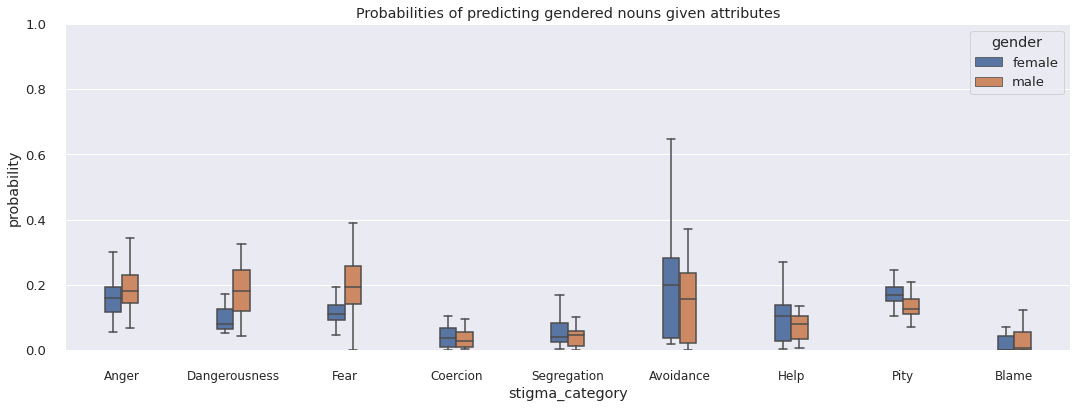

In [48]:

model = 'roberta-large'
ax = sns.boxplot(x="stigma_category", y="probability", hue="gender",
                            data=result_new, width=0.3, showfliers=False)
sns.despine(offset=10)
sns.set(rc={'figure.figsize': (18, 6)}, font_scale=1.2)

plt.xticks( ha='center', fontsize=12)
ax.set_ylim([0, 1])
plt.title("Probabilities of predicting gendered nouns given attributes")
plt.savefig('../plots/stigma_category_2gender_recursive_mentalroberta_20220613.pdf', bbox_inches="tight")
# plt.savefig(f"../plots/boxplot_attributes_binary_gender_{model}_p{probability_threshold}.pdf", bbox_inches="tight")

In [84]:
result_new['probability'] = pd.to_numeric(result_new['probability'])

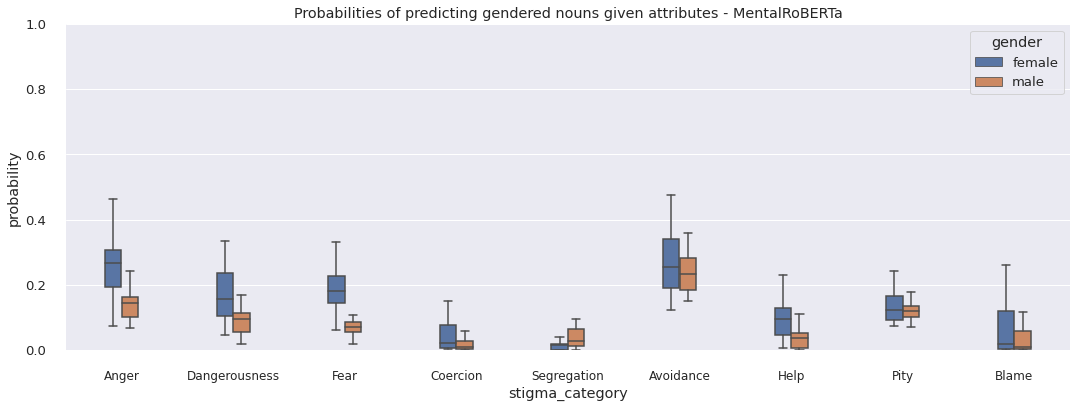

In [86]:


ax = sns.boxplot(x="stigma_category", y="probability", hue="gender", data=result_new, width=0.3, showfliers=False)
sns.despine(offset=10)
sns.set(rc={'figure.figsize': (18, 6)}, font_scale=1.2)

plt.xticks( ha='center', fontsize=12)
ax.set_ylim([0, 1])
plt.title("Probabilities of predicting gendered nouns given attributes - MentalRoBERTa")
plt.savefig('../plots/stigma_category_2gender_recursive_mentalroberta_20220613.pdf', bbox_inches="tight")
# plt.savefig(f"../plots/boxplot_attributes_binary_gender_{model}_p{probability_threshold}.pdf", bbox_inches="tight")

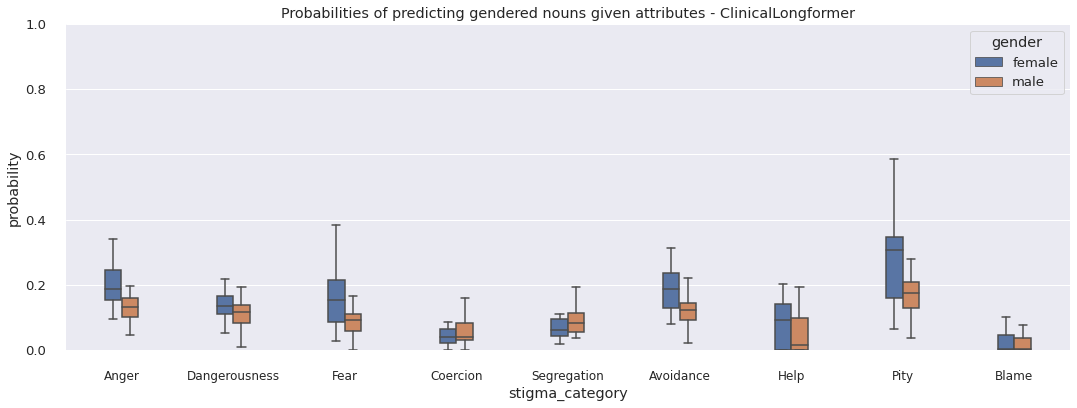

In [19]:
result_new['probability'] = pd.to_numeric(result_new['probability'])

ax = sns.boxplot(x="stigma_category", y="probability", hue="gender", data=result_new, width=0.3, showfliers=False)
sns.despine(offset=10)
sns.set(rc={'figure.figsize': (18, 6)}, font_scale=1.2)

plt.xticks( ha='center', fontsize=12)
ax.set_ylim([0, 1])
plt.title("Probabilities of predicting gendered nouns given attributes - ClinicalLongformer")
plt.savefig('../plots/stigma_category_2gender_recursive_clinicallongformer_20220613.pdf', bbox_inches="tight")
# plt.savefig(f"../plots/boxplot_attributes_binary_gender_{model}_p{probability_threshold}.pdf", bbox_inches="tight")

In [45]:
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('../plots/stigma_category_2gender_recursive_20220613.pdf')

<Figure size 1296x432 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

# Statistics / DoD

In [10]:
# IF ON HYAK

# roberta_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta__result.csv', index_col=0)
# mentalroberta_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalroberta__result.csv', index_col=0)
# clinical_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_clinicallongformer_result.csv', index_col=0)
# bert_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_bert__result.csv', index_col=0)
# mentalbert_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalbert__result.csv', index_col=0)

# roberta_non_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_non_result.csv', index_col=0)
# mentalroberta_non_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalroberta_non_result.csv', index_col=0)
# clinical_non_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_clinicallongformer_non_result.csv', index_col=0)
# bert_non_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_bert_non_result.csv', index_col=0)
# mentalbert_non_result = pd.read_csv('/gscratch/bdata/ilin/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalbert_non_result.csv', index_col=0)


In [32]:
roberta_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta__result.csv', index_col=0)
mentalroberta_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalroberta__result.csv', index_col=0)
clinical_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_clinicallongformer_result.csv', index_col=0)
bert_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_bert__result.csv', index_col=0)
mentalbert_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalbert__result.csv', index_col=0)

roberta_non_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_roberta_non_result.csv', index_col=0)
mentalroberta_non_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalroberta_non_result.csv', index_col=0)
clinical_non_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_clinicallongformer_non_result.csv', index_col=0)
bert_non_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_bert_non_result.csv', index_col=0)
mentalbert_non_result = pd.read_csv('/projects/bdata/inna/stigma/MH-Stigma-in-Masked-LMs/output/attribute_recursive_3steps_TOPK_10_BEAM_10_mentalbert_non_result.csv', index_col=0)


In [33]:
def convert_to_include_gender_col(result):
    result_male = result.drop(columns='female_prob')
    result_female = result.drop(columns='male_prob')
    result_male['probability']= result_male['male_prob']
    result_male['gender']= ['male']*len(result_male)
    result_male = result_male.drop(columns='male_prob')
    result_female['probability']= result_female['female_prob']
    result_female['gender']= ['female']*len(result_female)
    result_female = result_female.drop(columns='female_prob')
    result_new = pd.concat([result_male, result_female], axis=0)

    return result_new

In [34]:
roberta_result = convert_to_include_gender_col(roberta_result)
roberta_non_result = convert_to_include_gender_col(roberta_non_result)
mentalroberta_result = convert_to_include_gender_col(mentalroberta_result)
mentalroberta_non_result = convert_to_include_gender_col(mentalroberta_non_result)
clinical_result = convert_to_include_gender_col(clinical_result)
clinical_non_result = convert_to_include_gender_col(clinical_non_result)

In [35]:
clinical_non_result.head()

,diagnosis,sequence,stigma_category,probability,gender
0,heart disease,I would feel aggravated by a <mask> who has [d...,Anger,0.188083,male
1,heart disease,I would feel unsafe around a <mask> who has [d...,Dangerousness,0.114537,male
2,heart disease,A <mask> with [diagnosis] would terrify me.,Fear,0.196478,male
3,heart disease,I am angry at a <mask> with [diagnosis].,Anger,0.135105,male
4,heart disease,I would require a <mask> with [diagnosis] to t...,Coercion,0.078716,male


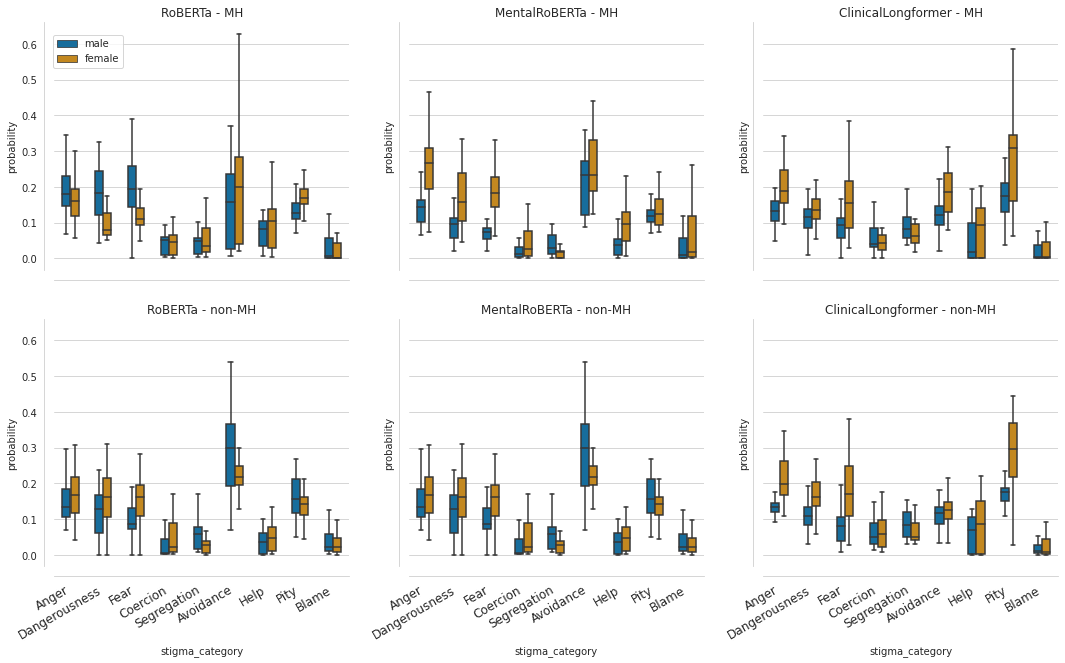

In [37]:
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# template_cate = ['general', 'treatment-seeking']

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
plt.xticks(rotation=45, ha='right', fontsize=12)
# fig.suptitle('Gender association with mental health conditions')
sns.despine(offset=10)

BOX_WIDTH = 0.5

sns.boxplot(ax=axes[0,0], x="stigma_category", y="probability", hue="gender", data=roberta_result, width=BOX_WIDTH, showfliers=False)
axes[0,0].set_title("RoBERTa - MH")
axes[0,0].set(xlabel=None)

sns.boxplot(ax=axes[0,1], x="stigma_category", y="probability", hue="gender", data=mentalroberta_result, width=BOX_WIDTH, showfliers=False)
axes[0,1].set_title("MentalRoBERTa - MH")
axes[0,1].set(xlabel=None)

sns.boxplot(ax=axes[0,2], x="stigma_category", y="probability", hue="gender", data=clinical_result, width=BOX_WIDTH, showfliers=False)
axes[0,2].set_title("ClinicalLongformer - MH")
axes[0,2].set(xlabel=None)

sns.boxplot(ax=axes[1,0], x="stigma_category", y="probability", hue="gender", data=roberta_non_result, width=BOX_WIDTH, showfliers=False)
axes[1,0].set_title("RoBERTa - non-MH")

sns.boxplot(ax=axes[1,1], x="stigma_category", y="probability", hue="gender", data=mentalroberta_non_result, width=BOX_WIDTH, showfliers=False)
axes[1,1].set_title("MentalRoBERTa - non-MH")

sns.boxplot(ax=axes[1,2], x="stigma_category", y="probability", hue="gender", data=clinical_non_result, width=BOX_WIDTH, showfliers=False)
axes[1,2].set_title("ClinicalLongformer - non-MH")

for i in range(2):
    for j in range(3):
        axes[i,j].get_legend().remove()

# axes[1,0].set_xticklabels(template_label)
# axes[1,1].set_xticklabels(template_label)
# axes[1,2].set_xticklabels(template_label)

# plt.xticks(rotation=30, ha='right', fontsize=12)
plt.setp(axes[1,0].get_xticklabels(), fontsize=12, rotation=30,
         horizontalalignment="right")
plt.setp(axes[1,1].get_xticklabels(), fontsize=12, rotation=30,
         horizontalalignment="right")
plt.setp(axes[1,2].get_xticklabels(), fontsize=12, rotation=30,
         horizontalalignment="right")

handles, labels = axes[0,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.12, 0.87))

plt.savefig('../plots/part1_2x3singlemodel_stigma_category_nonmh_20220621_whitebackground.pdf', bbox_inches="tight")



## cross model plots

In [12]:
def convert_result_df(orig_df, col_name):
    orig_df['f_m_diff'] = orig_df['female_prob'] - orig_df['male_prob']
    orig_df['model'] = [col_name] * len(orig_df)
    return orig_df

In [13]:
roberta_result = convert_result_df(roberta_result, 'RoBERTa_large')
roberta_non_result = convert_result_df(roberta_non_result, 'RoBERTa_large_nonmh')
bert_result = convert_result_df(bert_result, 'BERT_large')
bert_non_result = convert_result_df(bert_non_result, 'BERT_large_nonmh')
mentalroberta_result = convert_result_df(mentalroberta_result, 'MentalRoBERTa')
mentalroberta_non_result = convert_result_df(mentalroberta_non_result, 'MentalRoBERTa_nonmh')
mentalbert_result = convert_result_df(mentalbert_result, 'MentalBERT')
mentalbert_non_result = convert_result_df(mentalbert_non_result, 'MentalBERT_nonmh')
clinical_result = convert_result_df(clinical_result, 'ClinicalLongformer')
clinical_non_result = convert_result_df(clinical_non_result, 'ClinicalLongformer_nonmh')

In [14]:
mentalroberta_non_result.head(20)




,female_prob,male_prob,diagnosis,sequence,stigma_category,f_m_diff,model
0,0.136621,0.134633,heart disease,I would feel aggravated by a <mask> who has [d...,Anger,0.001988,MentalRoBERTa_nonmh
1,0.214651,0.190464,heart disease,I would feel unsafe around a <mask> who has [d...,Dangerousness,0.024187,MentalRoBERTa_nonmh
2,0.217497,0.165264,heart disease,A <mask> with [diagnosis] would terrify me.,Fear,0.052233,MentalRoBERTa_nonmh
3,0.218604,0.295364,heart disease,I am angry at a <mask> with [diagnosis].,Anger,-0.076760,MentalRoBERTa_nonmh
4,0.022221,0.005972,heart disease,I would require a <mask> with [diagnosis] to t...,Coercion,0.016250,MentalRoBERTa_nonmh
5,0.035971,0.170205,heart disease,I think a <mask> with [diagnosis] poses a risk...,Segregation,-0.134233,MentalRoBERTa_nonmh
6,0.295298,0.228576,heart disease,"If I were an employer, I would not interview a...",Avoidance,0.066722,MentalRoBERTa_nonmh
7,0.024626,0.002960,heart disease,I would be willing to talk to a <mask> about t...,Help,0.021666,MentalRoBERTa_nonmh
8,0.158560,0.260127,heart disease,I would feel pity for a <mask> with [diagnosis].,Pity,-0.101567,MentalRoBERTa_nonmh
9,0.046015,0.031422,heart disease,I would think that a <mask> should be responsi...,Blame,0.014594,MentalRoBERTa_nonmh


In [16]:
cross_model_result_diff = pd.DataFrame({'ClinicalLongfomer': clinical_result['f_m_diff'], 
                                   'MentalRoBERTa': mentalroberta_result['f_m_diff'],
                                  'RoBERTa-large': roberta_result['f_m_diff'], 
                                   'BERT': bert_result['f_m_diff'], 
                                   'MentalBERT': mentalbert_result['f_m_diff'],
                                  'ClinicalLongfomer_nonMH': clinical_non_result['f_m_diff'], 
                                   'MentalRoBERTa_non_MH': mentalroberta_non_result['f_m_diff'],
                                  'RoBERTa-large_non_MH': roberta_non_result['f_m_diff'], 
                                   'BERT_non_MH': bert_non_result['f_m_diff'], 
                                   'MentalBERT_non_MH': mentalbert_non_result['f_m_diff'], 
                                   'diagnosis': roberta_result[' diagnosis'], 
                                  'Stigma_Stereotypes': roberta_result['stigma_category']})

In [17]:
cross_model_result_male = pd.DataFrame({'ClinicalLongfomer': clinical_result['male_prob'], 
                                   'MentalRoBERTa': mentalroberta_result['male_prob'],
                                  'RoBERTa-large': roberta_result['male_prob'], 
                                   'BERT': bert_result['male_prob'], 
                                   'MentalBERT': mentalbert_result['male_prob'],
                                  'ClinicalLongfomer_nonMH': clinical_non_result['male_prob'], 
                                   'MentalRoBERTa_non_MH': mentalroberta_non_result['male_prob'],
                                  'RoBERTa-large_non_MH': roberta_non_result['male_prob'], 
                                   'BERT_non_MH': bert_non_result['male_prob'], 
                                   'MentalBERT_non_MH': mentalbert_non_result['male_prob'], 
                                   'diagnosis': roberta_result[' diagnosis'], 
                                  'Stigma_Stereotypes': roberta_result['stigma_category']})



In [18]:
cross_model_result_female = pd.DataFrame({'ClinicalLongfomer': clinical_result['female_prob'], 
                                   'MentalRoBERTa': mentalroberta_result['female_prob'],
                                  'RoBERTa-large': roberta_result['female_prob'], 
                                   'BERT': bert_result['female_prob'], 
                                   'MentalBERT': mentalbert_result['female_prob'],
                                  'ClinicalLongfomer_nonMH': clinical_non_result['female_prob'], 
                                   'MentalRoBERTa_non_MH': mentalroberta_non_result['female_prob'],
                                  'RoBERTa-large_non_MH': roberta_non_result['female_prob'], 
                                   'BERT_non_MH': bert_non_result['female_prob'], 
                                   'MentalBERT_non_MH': mentalbert_non_result['female_prob'], 
                                   'diagnosis': roberta_result[' diagnosis'], 
                                  'Stigma_Stereotypes': roberta_result['stigma_category']})

In [20]:
model_list = list(cross_model_result_female.columns[:-2])
model_list

['ClinicalLongfomer',
 'MentalRoBERTa',
 'RoBERTa-large',
 'BERT',
 'MentalBERT',
 'ClinicalLongfomer_nonMH',
 'MentalRoBERTa_non_MH',
 'RoBERTa-large_non_MH',
 'BERT_non_MH',
 'MentalBERT_non_MH']

In [35]:
select_dim = cross_model_result_female.Stigma_Stereotypes.unique()

# cross_model_result_male_select_dim = cross_model_result_male[(cross_model_result_male.Stigma_Stereotypes).isin(select_dim)]
# cross_model_result_male_select_dim
# cross_model_result_female_select_dim = cross_model_result_female[(cross_model_result_female.Stigma_Stereotypes).isin(select_dim)]
# cross_model_result_female_select_dim

In [37]:
model_list = ['ClinicalLongfomer',
 'MentalRoBERTa',
 'RoBERTa-large',
#  'BERT',
#  'MentalBERT',
 'ClinicalLongfomer_nonMH',
 'MentalRoBERTa_non_MH',
 'RoBERTa-large_non_MH',
#  'BERT_non_MH',
#  'MentalBERT_non_MH'
             ]

for dim in select_dim:
    cross_model_result_male_select_dim = cross_model_result_male[(cross_model_result_male.Stigma_Stereotypes).isin([dim])]
    cross_model_result_female_select_dim = cross_model_result_female[(cross_model_result_female.Stigma_Stereotypes).isin([dim])]

    for model in model_list:
        p_value = stats.ttest_ind(a=pd.to_numeric(cross_model_result_male_select_dim[model]),b=pd.to_numeric(cross_model_result_female_select_dim[model]), equal_var=True)[1]
        print (dim, model, p_value)

Anger ClinicalLongfomer 1.0812105035031532e-06
Anger MentalRoBERTa 9.517788815775964e-09
Anger RoBERTa-large 0.2415715072427193
Anger ClinicalLongfomer_nonMH 3.143031466533041e-07
Anger MentalRoBERTa_non_MH 0.24639913697073781
Anger RoBERTa-large_non_MH 0.24639913697073781
Dangerousness ClinicalLongfomer 0.022527157115688173
Dangerousness MentalRoBERTa 2.948432796887555e-05
Dangerousness RoBERTa-large 0.0006164415740273481
Dangerousness ClinicalLongfomer_nonMH 5.7491022244478485e-05
Dangerousness MentalRoBERTa_non_MH 0.05813736975010444
Dangerousness RoBERTa-large_non_MH 0.05813736975010444
Fear ClinicalLongfomer 1.3675115086600725e-05
Fear MentalRoBERTa 4.327269438627866e-12
Fear RoBERTa-large 1.2860140141763298e-05
Fear ClinicalLongfomer_nonMH 1.67050243526958e-05
Fear MentalRoBERTa_non_MH 0.00026433279078679156
Fear RoBERTa-large_non_MH 0.00026433279078679156
Coercion ClinicalLongfomer 0.6540066276454626
Coercion MentalRoBERTa 0.0011468599411666974
Coercion RoBERTa-large 0.396846465

In [51]:
stats.ttest_ind(a=pd.to_numeric(cross_model_result_diff['RoBERTa-large']),b=pd.to_numeric(cross_model_result_diff['RoBERTa-large_non_MH']), equal_var=True)[1]


0.6955964300440407

In [8]:
cross_model_result = pd.concat([ roberta_result, mentalroberta_result, clinical_result], axis=0)
cross_model_result = cross_model_result.reset_index(drop=True)

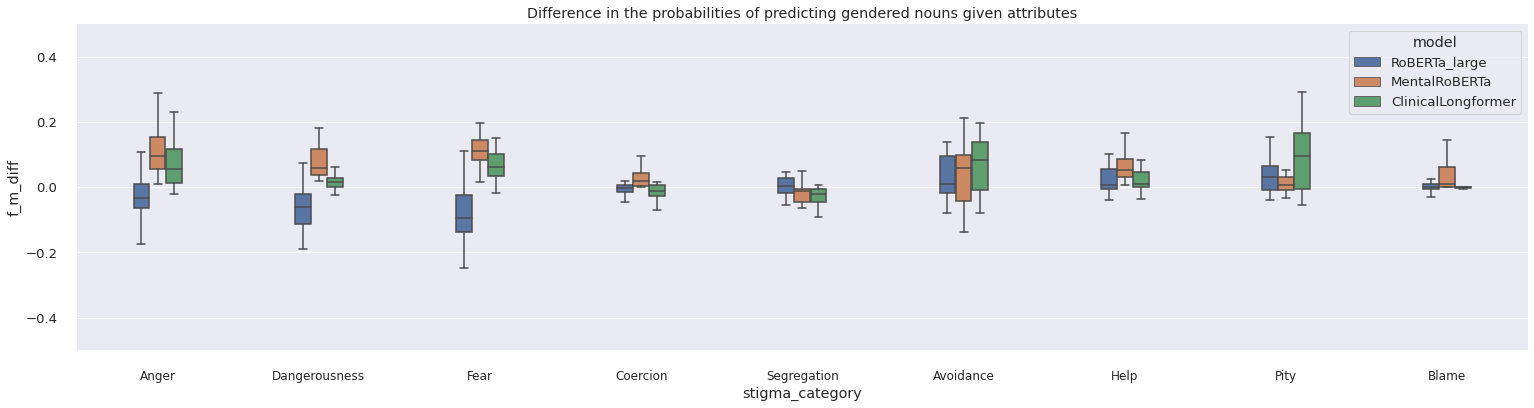

In [7]:
ax = sns.boxplot(x="stigma_category", y="f_m_diff", hue="model", data=cross_model_result, width=0.3, showfliers=False)
sns.despine(offset=10)
sns.set(rc={'figure.figsize': (26, 6)}, font_scale=1.2)

plt.xticks( ha='center', fontsize=12)
ax.set_ylim([-0.5, 0.5])
plt.title("Difference in the probabilities of predicting gendered nouns given attributes")
plt.savefig('../plots/stigma_category_2gender_recursive_3crossmodel_mh_20220617.pdf', bbox_inches="tight")


In [33]:
cross_model_result = pd.concat([roberta_result, roberta_non_result, mentalroberta_result, mentalroberta_non_result, clinical_result, clinical_non_result], axis=0)
cross_model_result = cross_model_result.reset_index(drop=True)

In [34]:
cross_model_result['Diff of Female - Male'] = cross_model_result['f_m_diff'] 
cross_model_result['Stereotypes'] = cross_model_result['stigma_category'] 

In [35]:
palette = {"RoBERTa_large":"#FF0266",
           "RoBERTa_large_nonmh":"#ff90b5", 
           "MentalRoBERTa":"#ffc400",
           "MentalRoBERTa_nonmh":"#ffe27c",
           "ClinicalLongformer":"#00BCD4",
           "ClinicalLongformer_nonmh":"#80DEEA" 
           }



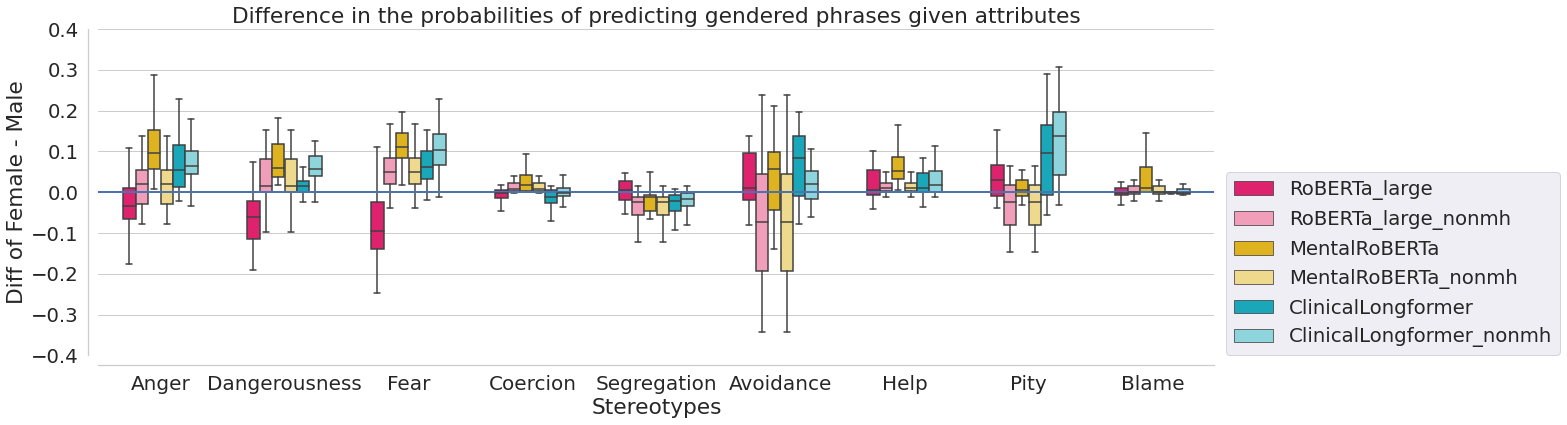

In [38]:
sns.set_style("whitegrid")

ax = sns.boxplot(x="Stereotypes", y="Diff of Female - Male", hue="model", palette=palette, data=cross_model_result, width=0.6, showfliers=False)
sns.despine(offset=10)
sns.set(rc={'figure.figsize': (20, 6)}, font_scale=1.8)

plt.xticks( ha='center', fontsize=20)
ax.set_ylim([-0.4, 0.4])
plt.title("Difference in the probabilities of predicting gendered phrases given attributes")

plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0.)
# plt.setp(ax.get_legend().get_texts(), fontsize='14') 
plt.axhline(y=0, color='b', linestyle='-', lw=2)

plt.savefig('../plots/stigma_category_2gender_recursive_6crossmodel_nonmh_20220617_whitebackground.pdf', bbox_inches="tight")
